Getting Data

In [1]:
!rm -rf DATA*
!wget https://filebin.net/archive/7c3hnzpxu75h6dxj/zip -O DATA.zip
!unzip DATA.zip -d DATA
!ls

--2024-03-15 00:44:14--  https://filebin.net/archive/7c3hnzpxu75h6dxj/zip
Resolving filebin.net (filebin.net)... 88.99.137.18, 2a01:4f8:10a:2156::2
Connecting to filebin.net (filebin.net)|88.99.137.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘DATA.zip’

DATA.zip                [ <=>                ] 756.85K  --.-KB/s    in 0.09s   

2024-03-15 00:44:14 (8.16 MB/s) - ‘DATA.zip’ saved [775011]

Archive:  DATA.zip
 extracting: DATA/DATA_A.xlsx        
 extracting: DATA/DATA_B.xlsx        
 extracting: DATA/DATA_C.xlsx        
 extracting: DATA/DATA_D.xlsx        
 extracting: DATA/DATA_E.xlsx        
 extracting: DATA/DATA_F.xlsx        
 extracting: DATA/DATA_G.xlsx        
 extracting: DATA/DATA_H.xlsx        
 extracting: DATA/DATA_I.xlsx        
 extracting: DATA/DATA_J.xlsx        
1000.h5  DATA  DATA.zip  final.h5  NIFTY_Indices.xlsx  pct.h5  pred_index.h5  sample_data


Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import csv

Loading Data

In [3]:
DIR = "DATA"
COL = "Close"
DATA = {}

for file in os.listdir(DIR):
  path = os.path.join(DIR, file)
  stock = path.split(".")[0].split("_")[-1]
  df = pd.read_excel(path)
  DATA[stock] = df
  print(stock, len(df))

DATA_NORM = {}
for stock in DATA:
  df = DATA[stock]
  last = df[COL].iloc[-1]
  df[COL] = df[COL]/last
  DATA_NORM[stock] = df

J 1236
A 1236
H 1236
D 1236
E 1236
I 1236
B 1236
F 1236
G 1236
C 1236


In [4]:
INDICES = {}
idf = pd.read_excel("NIFTY_Indices.xlsx", sheet_name=None)

for i in idf:
  # idf[i][COL] = idf[i][COL].pct_change(1)
  last = idf[i][COL][idf[i]['Date'] == '2022-12-30'].iloc[0]
  # print(i, last)
  idf[i][COL] = idf[i][COL] / last

TRAIN_INDICES = {}
for index in idf:
  TRAIN_INDICES[index] = idf[index][idf[index]['Date'].isin(DATA['A']['Date'])]
  # print(index, len(TRAIN_INDICES[index]), last)

# TEST_INDICES = {}
# for index in idf:
#   TEST_INDICES[index] = idf[index][idf[index]['Date'] >= '2023-01-01']
#   # print(index, len(TEST_INDICES[index]), last)

Plotting

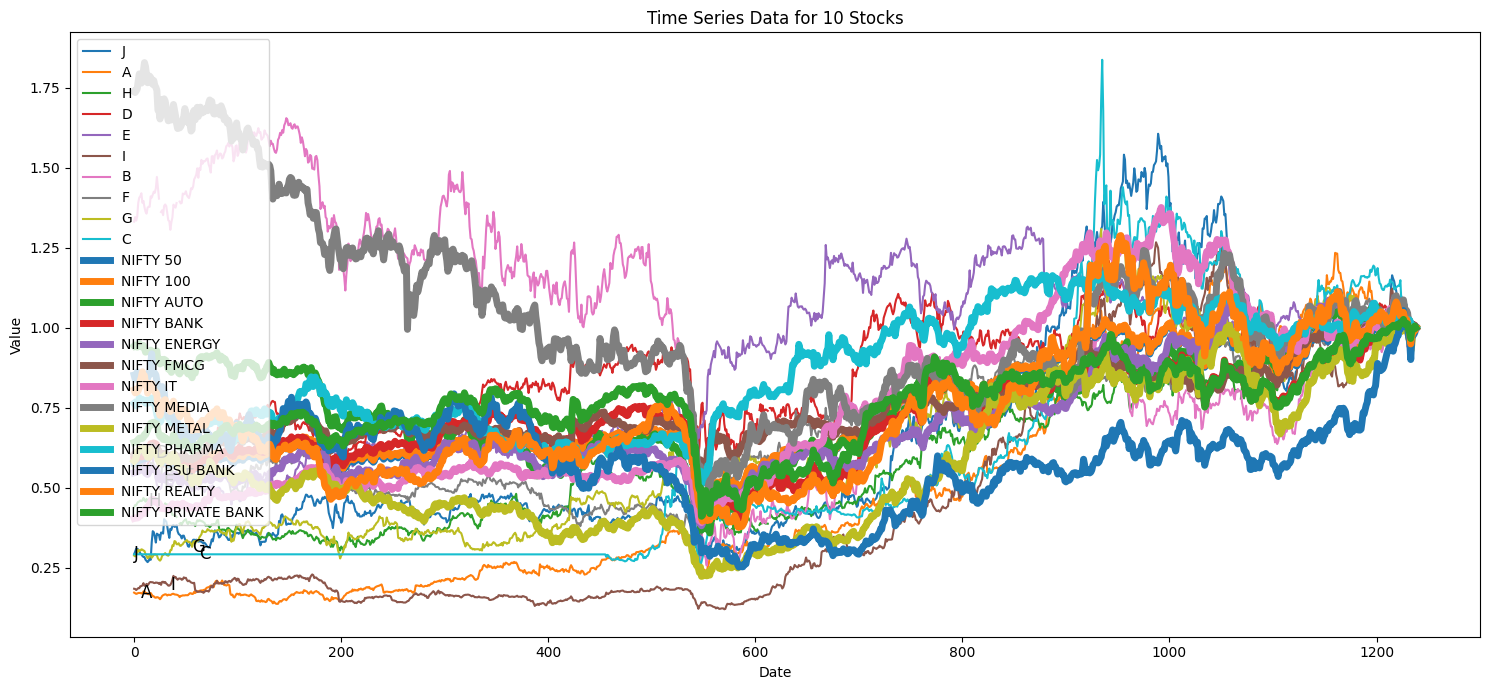

In [5]:
plt.figure(figsize=(15, 7))
i = 0

for stock in DATA_NORM:
  df = DATA_NORM[stock]
  plt.plot(df.index, df[COL], label=stock)
  value = df[COL].iloc[i*7]
  date = df.index[i*7]
  # Adjust the y position to avoid overlapping. You could customize this based on your data.
  plt.text(date, value, f'{stock}', fontsize=12, verticalalignment='center')
  i += 1
for idx in TRAIN_INDICES:
  df = TRAIN_INDICES[idx]
  plt.plot(df.index, df[COL], label=idx, linewidth=5)

plt.title('Time Series Data for 10 Stocks')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

Sharpe Ratio gives us that B is a bad stock

In [6]:
def calculate_sharpe_ratio(stock, risk_free_rate=0):
    returns = stock.pct_change(1)
    excess_returns = returns - risk_free_rate
    avg_excess_return_annual = excess_returns.mean() * 252
    std_dev_annual = excess_returns.std() * np.sqrt(252)
    sharpe_ratio = avg_excess_return_annual / std_dev_annual
    return sharpe_ratio

for stock in DATA:
  df = DATA[stock][COL]
  print(stock, calculate_sharpe_ratio(df))

J 0.8137248537225475
A 1.1773232026491744
H 0.7080911152241207
D 0.5565120473472382
E 0.5511367949929129
I 1.1142339999997808
B 0.13415797764748644
F 0.5490409817239337
G 0.9188585866880568
C 0.8810379156321887


In [7]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return rsi.iloc[-1]

for stock in DATA:
    df = DATA[stock][COL]
    print(stock, calculate_rsi(df, 14))

J 36.36301682276215
A 44.62586508477569
H 31.27539628159539
D 36.475826800426844
E 31.890973421609075
I 38.16252020632191
B 53.02477603847629
F 42.777928961396775
G 50.4767441334311
C 28.12092878627348


In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
def create_sequences(data, target, sequence_length):
    X, y = [], []
    classes = data.shape[0]
    num = data.shape[1]
    for i in range(num - sequence_length):
        X.append(np.transpose(data[:, i:i+sequence_length]))
        y.append(np.transpose(target[:23, i+sequence_length]))
    return np.array(X), np.array(y)

sequence_length = 90
data = np.stack([DATA[stock][COL] for stock in "ABCDEFGHIJ"]+[TRAIN_INDICES[x][COL] for x in TRAIN_INDICES])
#
data[np.isnan(data)] = 1
print(data.shape)
target = np.roll(data, -1, axis=-1)
target[:, -1] = 1
X, y = create_sequences(data, target, sequence_length)
print(X.shape)
print(y.shape)

(23, 1236)
(1146, 90, 23)
(1146, 23)


In [11]:
model = Sequential([
    LSTM(256, input_shape=(sequence_length, 23), return_sequences=True),
    LSTM(128),
    Dense(100),
    Dense(23)
])

In [12]:
model.compile(optimizer='adam', loss='mse')

In [13]:
model.fit(X, y, epochs=500, batch_size=1000, validation_split=0.2)

Epoch 1/500
1/1 [==============================] - 12s 12s/step - loss: 0.4945 - val_loss: 0.4944
Epoch 2/500
1/1 [==============================] - 0s 185ms/step - loss: 0.2545 - val_loss: 0.2313
Epoch 3/500
1/1 [==============================] - 0s 139ms/step - loss: 0.1085 - val_loss: 0.1084
Epoch 4/500
1/1 [==============================] - 0s 137ms/step - loss: 0.0549 - val_loss: 0.0779
Epoch 5/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0594 - val_loss: 0.0635
Epoch 6/500
1/1 [==============================] - 0s 134ms/step - loss: 0.0573 - val_loss: 0.0529
Epoch 7/500
1/1 [==============================] - 0s 131ms/step - loss: 0.0468 - val_loss: 0.0503
Epoch 8/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0359 - val_loss: 0.0541
Epoch 9/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0287 - val_loss: 0.0580
Epoch 10/500
1/1 [==============================] - 0s 137ms/step - loss: 0.0258 - val_loss: 0.0619
Epoch 11/5

In [14]:
model.predict(X[-100].reshape((1, sequence_length, 23)))

1/1 [==============================] - 1s 907ms/step


array([[0.9436662 , 0.9013998 , 1.2231596 , 1.025835  , 1.1873248 ,
        0.8588547 , 1.0401552 , 0.784926  , 0.9326772 , 1.1824358 ,
        1.0202501 , 1.0165741 , 0.8984926 , 0.8457062 , 0.9268967 ,
        0.96452695, 1.1199293 , 1.1719857 , 0.8622998 , 1.1308783 ,
        0.6140146 , 1.1018654 , 0.8717476 ]], dtype=float32)

In [15]:
y[-100]

array([1.0831968 , 0.86004916, 1.02735444, 1.00947195, 0.99664908,
       0.95687541, 1.04455909, 0.99486789, 0.97226747, 0.97454901,
       0.96795413, 0.97404258, 1.02507592, 0.88952216, 1.03320468,
       0.97299274, 1.04702726, 1.05579679, 0.84302585, 1.02719963,
       0.65225597, 1.01574803, 0.89141661])

In [16]:
# def next_index(i):
#   x = []
#   for idx in TEST_INDICES:
#     x.append(TEST_INDICES[idx][COL].iloc[i])
#   n = np.array(x)
#   d = n.shape[-1]
#   n = np.reshape(n, (1,1,d))
#   return n
# next_index(0)

In [17]:
result = []
current_seq = np.array([np.transpose(data[:, -sequence_length:])])
print(current_seq.shape)

for i in range(246):
    pred_step = model.predict(current_seq, verbose=False)

    result.append(pred_step[0])
    inp = np.array([[pred_step[0][:23]]])
    # inp = np.append(inp, next_index(i), axis=-1)

    current_seq = np.append(current_seq[:,1:], inp, axis=1)

(1, 90, 23)


In [18]:
r = np.transpose(np.array(result)).tolist()

In [19]:
len(r[0])

246

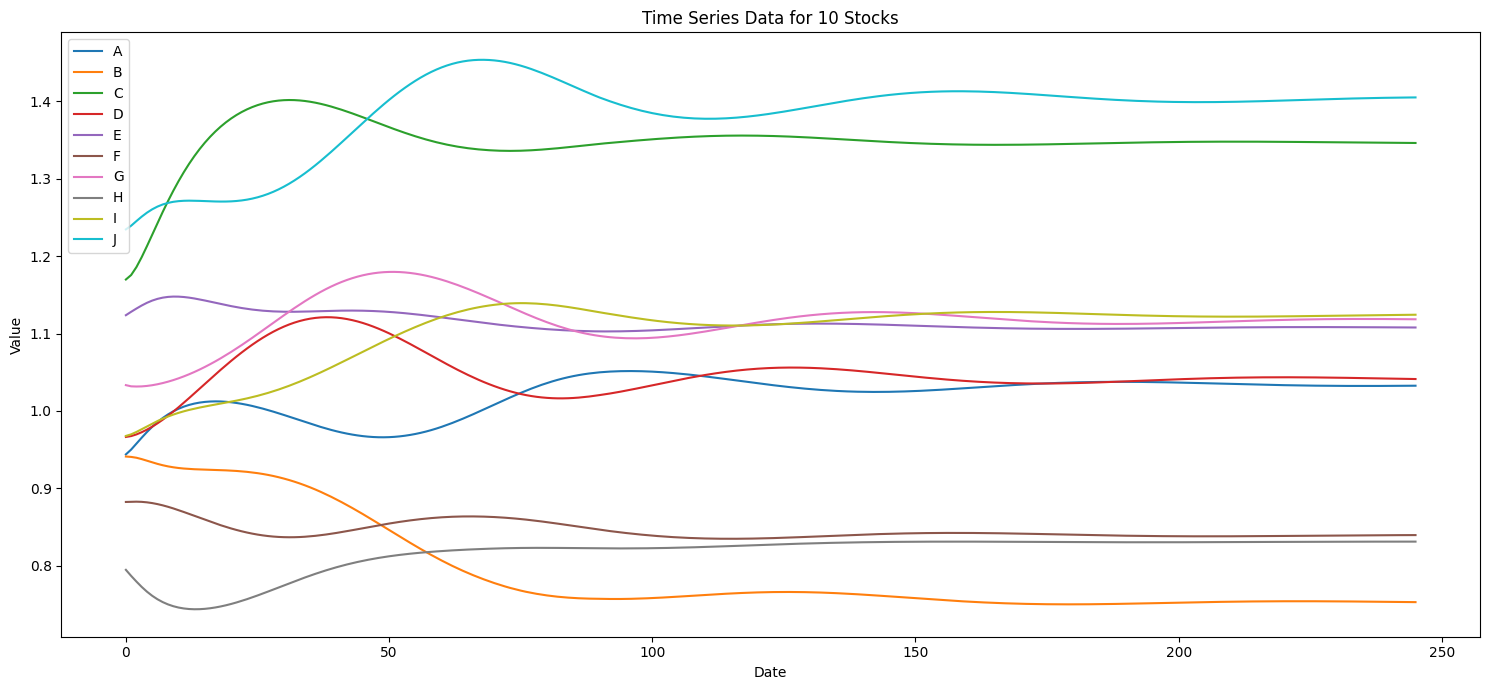

In [20]:
plt.figure(figsize=(15, 7))
s = "ABCDEFGHIJ"
for stock, i in zip(r[:10], range(10)):
  plt.plot(stock, label=s[i])
plt.title('Time Series Data for 10 Stocks')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
s = 'ABCDEFGHIJ'
for i in range(10):
  print(s[i], (r[i][-1]-r[i][0])/r[i][0])

A 0.09391475942637499
B -0.19974211657683408
C 0.15069465647921412
D 0.07736187102594871
E -0.01412133552743463
F -0.048462755440591226
G 0.08227471356125382
H 0.045839604163668876
I 0.161698402934027
J 0.13799816963877454


In [22]:
model.save("pred_index.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
